In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score

In [145]:
import xgboost
from xgboost import XGBClassifier

In [185]:
train=pd.read_csv("./Data/Training_dataset_Original.csv", low_memory=False)
test=pd.read_csv("./Data/Leaderboard_dataset.csv", low_memory=False)

In [186]:
data.shape

(105000, 51)

In [187]:
def replace_nan(data):
    data = data.replace("nan", np.nan)
    data = data.replace("missing", np.nan)
    data = data.replace("na", np.nan)
    return data

In [188]:
train = replace_nan(train)
test = replace_nan(test)

In [189]:
def fill_data(data):
    data['mvar47'] = data['mvar47'] == 'C'
    data = data.astype(dtype='float64')
    data = data.fillna(data.median())
#     data = data.fillna(data.mean())
    return data

In [190]:
train = fill_data(train)
test = fill_data(test)

In [191]:
data=pd.concat([train, test], sort=False)
# data=pd.concat([train.drop('default_ind', axis=1), test])

In [192]:
test.head()

,application_key,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,350053.0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,350054.0,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,350055.0,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,350056.0,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,350057.0,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [193]:
def preparing_data(train,test):

    categorical = ["mvar16", "mvar34"]

    def replacing_categorical(X):
        x=train.groupby(X)["default_ind"].mean()
        y=train.groupby(X)["default_ind"].std()
#         data[X+str("_mean")]= data[X].apply(lambda X1: x[X1])
#         data[X+str("_std")] = data[X].apply(lambda X2: y[X2])

    for i in categorical:
        replacing_categorical(i)
   
    train_new = data.iloc[0:train.shape[0]]
    test_new = data.iloc[train.shape[0]:data.shape[0]]

    def prepare_data(df, is_train):
        # Dropping cm_key
#         df = df.drop(["application_id"], axis=1)
        # Dropping mvar1 due to uniformity
#         df  = df.drop(["mvar1"], axis=1)
        if is_train:
            return df.drop(['application_key',"default_ind", "mvar21", "mvar22", "mvar23"], axis=1), df['default_ind']
        return df.drop(['application_key',"default_ind", "mvar21", "mvar22", "mvar23"], axis=1)


    train_features, train_target = prepare_data(train_new, 1)
    test_features = prepare_data(test_new, 0)
    
    return train_features, train_target, test_features

In [194]:
train_features, train_target, test_features = preparing_data(train,test)

In [195]:
test_features.head()

,mvar1,mvar2,mvar3,mvar4,mvar5,mvar6,mvar7,mvar8,mvar9,mvar10,...,mvar38,mvar39,mvar40,mvar41,mvar42,mvar43,mvar44,mvar45,mvar46,mvar47
0,1753.0,0.5001,0.000,0.0,0.0,206.0,19179.0,206.0,14221.0,19438.0,...,1.0,0.0,100.000,20.551,0.42105,3.0,0.85661,0.0,0.0,0.0
1,1894.0,1.9701,0.000,0.0,0.0,297.0,19820.0,19820.0,176895.0,66346.0,...,3.0,0.0,100.000,63.047,0.00000,15.0,0.94391,0.0,0.0,1.0
2,1774.0,0.1718,0.000,0.0,0.0,197.0,2563.0,877.0,8869.0,3637.0,...,1.0,0.0,100.000,83.797,0.33333,3.0,0.76467,0.0,0.0,1.0
3,1586.0,0.1123,5.299,0.0,0.0,297.0,7011.5,2503.0,14072.0,0.0,...,1.0,0.0,100.000,79.123,1.50000,0.0,0.73274,0.0,0.0,1.0
4,1832.0,1.4442,0.000,0.0,0.0,179.0,7577.0,179.0,21059.0,20306.0,...,3.0,0.0,96.052,66.665,0.00000,23.0,0.79190,0.0,0.0,0.0


In [196]:
def model(train,test):
    train_features, train_target, test_features = preparing_data(train,test)
    Xtrain, Xtest, ytrain, ytest = train_test_split( train_features, train_target,
                                                    stratify=train_target, test_size=.3, random_state=100)
    
    print(train_features.head())
#     train_features = train_features.values
#     test_features = test_features.values
    xgb = XGBClassifier(n_estimators= 1000, seed=100)
    xgb.fit(train_features, train_target)
    
    print ("Training :"+str(accuracy_score( ytrain, xgb.predict(Xtrain))))
    print ("Test :"+str(accuracy_score( ytest, xgb.predict(Xtest))))
    print ("ROC_AUC :"+str(roc_auc_score( ytest, xgb.predict(Xtest))))
    print ("precision_score :"+str(precision_score( ytest, xgb.predict(Xtest))))
    print ("recall_score :"+str(recall_score( ytest, xgb.predict(Xtest))))
    print ("confusion_matrix :"+ str(confusion_matrix(ytest, xgb.predict(Xtest))))

    def myscorer(cm):
        False1 = cm[0][1]
        False2 = cm[1][0]
        return (3*False1) + (False2), (False1+False2)

    print ("myscorer :"+ str(myscorer(confusion_matrix(ytest, xgb.predict(Xtest)))))
           
    ax = xgboost.plot_importance(xgb)
    fig = ax.figure
    fig.set_size_inches(15, 15)

In [172]:
# train = train.astype(dtype='float64')
# test = test.astype(dtype='float64')

    mvar1   mvar2  mvar3  mvar4  mvar5   mvar6    mvar7   mvar8    mvar9  \
0  1696.0  1.6541  0.000    0.0    0.0     0.0   6015.0   322.0  40369.0   
1  1846.0  0.8095  0.000    0.0    0.0   102.0   7532.0  3171.0  18234.0   
2  1745.0  0.4001  0.000    0.0    0.0   297.0   2536.0  2478.0  14171.0   
3  1739.0  0.2193  0.000    0.0    0.0  1982.0  26440.0  4955.0  20316.0   
4  1787.0  0.0118  0.225    0.0    0.0  5451.0   5494.0  5494.0   7987.0   

    mvar10   ...    mvar38  mvar39   mvar40   mvar41   mvar42  mvar43  \
0  18414.0   ...       4.0     1.0   73.780  82.5470  0.08696    10.0   
1  13664.0   ...       2.0     0.0   99.129  78.8835  0.00000    13.0   
2   2536.0   ...       1.0     0.0  100.000  29.2900  0.00000     1.0   
3  37013.0   ...       2.0     0.0   96.272  78.8835  0.15385     3.0   
4   4696.0   ...       2.0     0.0  115.019  78.8835  0.00000     1.0   

    mvar44  mvar45  mvar46  mvar47  
0  0.63899     0.0     0.0     1.0  
1  0.63836     0.0     0.0    

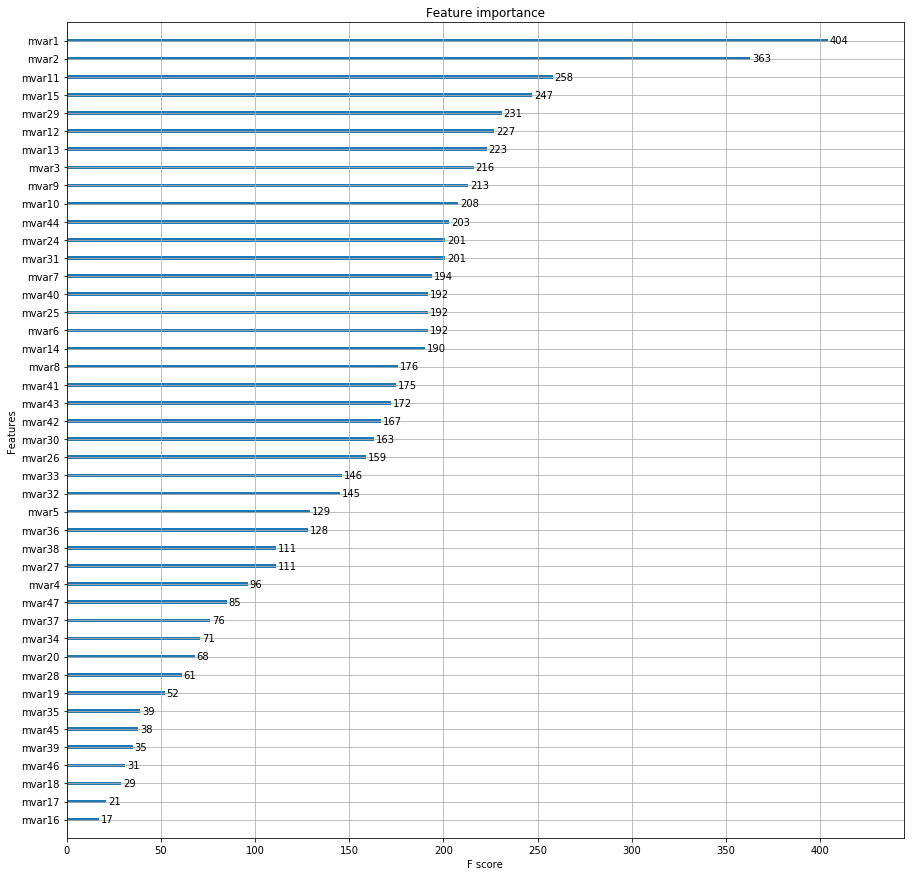

In [197]:
model(train, test)

In [198]:
train_features, train_target, test_features = preparing_data(train, test)
xgb = XGBClassifier(n_estimators= 1000, seed=100)
xgb.fit(train_features, train_target)
submission = pd.concat([test["application_key"], pd.DataFrame(xgb.predict_proba(test_features), columns=["0","1"])], axis=1)

In [200]:
# xgb.predict_proba(test_features)
test_features.shape

(25000, 44)

In [218]:
submission_pred = xgb.predict(test_features)

In [219]:
submission_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [220]:
submission.head()

,application_key,0,1
0,350053.0,0.963231,0.036769
1,350054.0,0.908026,0.091975
2,350055.0,0.888974,0.111026
3,350056.0,0.347829,0.652171
4,350057.0,0.908727,0.091273


In [203]:
# Y_pred=xgb1.predict(X_test)

In [204]:
# xgb1.predict_proba(X_test)

In [205]:
# float(np.sum(Y_pred == Y_test))/float(np.sum(Y_test == Y_test))

In [206]:
# metrics.accuracy_score(Y_test, Y_pred)

In [207]:
# X_lead = pd.read_csv('./RefinedData/refined_leaderboard_data.csv', low_memory=False)

In [208]:
# X_lead.head()

In [209]:
# Y_lead=pd.DataFrame(xgb1.predict(X_lead))

In [221]:
# Y_prob = xgb1.predict_proba(X_lead)
# Y_prob

In [222]:
submission

,application_key,0,1
0,350053.0,0.963231,0.036769
1,350054.0,0.908026,0.091975
2,350055.0,0.888974,0.111026
3,350056.0,0.347829,0.652171
4,350057.0,0.908727,0.091273
5,350058.0,0.996356,0.003644
6,350059.0,0.939659,0.060341
7,350060.0,0.994186,0.005814
8,350061.0,0.991020,0.008980
9,350062.0,0.738272,0.261728


In [223]:
# Y_wt = Y_prob[:,0]
Y_wt = submission.values[:, 1]
Y_wt = np.abs(Y_wt - 0.5)
Y_wt

array([0.46323115, 0.4080255 , 0.38897407, ..., 0.37435913, 0.46017814,
       0.48862952])

In [226]:
sol = pd.DataFrame()
sol['priority'] = pd.Series(Y_wt)
sol['application_key'] = submission['application_key'].astype(dtype='int')
sol['default_ind'] = submission_pred.astype(dtype='int')

In [227]:
sol.head()

,priority,application_key,default_ind
0,0.463231,350053,0
1,0.408026,350054,0
2,0.388974,350055,0
3,0.152171,350056,1
4,0.408727,350057,0


In [228]:
sol.sort_values(by = 'priority', ascending = False)

,priority,application_key,default_ind
22263,0.499697,372316,0
22306,0.499677,372359,0
4479,0.499652,354532,0
19883,0.499652,369936,0
12056,0.499616,362109,0
11416,0.499590,361469,0
17879,0.499566,367932,0
22268,0.499562,372321,0
22292,0.499505,372345,0
18577,0.499501,368630,0


In [229]:
#sol = sol.drop('priority', axis = 1)
sol.to_csv(path_or_buf='Analyzing_IITGuwahati_33.csv', index = False, header=False)